# Model-Predictive Path Integral Control Example

In [1]:
%load_ext autoreload
%autoreload 2

## Imports and Parameters

In [73]:
import time
import cv2
from utils import * # imports integrators and other useful things
from system import * # imports system dynamics and objective
from MPPI import MPPI # imports controller
import matplotlib.pyplot as plt
# %matplotlib widget
%matplotlib inline

###################
# System parameters
x0 = np.array([0,0,0,0])
xd = None
del_t = 0.1
dyn = lambda x, u: double_int(x,u)

######################
# Objective parameters
w_sz = 8; ov = 0.5;
R = 10.0*np.diag([1.0, 1.0])
Q = None
u0 = np.array([0.0, 0.0])
var_ind = [0,1]
w1 = 10 # weight on potential
w2 = -2 # weight on rattling (must be negative for diffusion)

#####################
# Image preprocessing
thresh = 0.97
dim = (100, 100)
im_extent = [[-1,1],[-1,1]]
img = cv2.imread('N.png')
resized = cv2.resize(img, dim, interpolation = cv2.INTER_AREA)
gray = cv2.cvtColor(resized, cv2.COLOR_BGR2GRAY)
img_potential = np.array(np.flip(gray.T,axis=1),dtype=np.float64)/np.max(gray)
img_potential[img_potential<thresh] = 0

#############################
# Image samples and objective
n_samp = 300
xlen = np.abs(im_extent[0][1]-im_extent[0][0])
ylen = np.abs(im_extent[1][1]-im_extent[1][0])
target_pts = np.array(np.where(img_potential < thresh),dtype=np.float64).T
xtemp = ((target_pts[:,0]/float(img_potential.shape[0]))*xlen)+im_extent[0][0]
ytemp = ((target_pts[:,1]/float(img_potential.shape[1]))*ylen)+im_extent[1][0]
scaled_pts = np.vstack([xtemp,ytemp]).T
samples = scaled_pts[np.random.choice(range(len(scaled_pts[:,0])),size=n_samp)]
obj = lambda x, u: image_objective(x, u, img_potential, samples, im_extent, var_ind, del_t, w1, w2, w_sz, ov, xd, Q, R)

#######################
# Controller parameters
noise_mean = np.array([0.0, 0.0])
noise_var = 0.1*np.diag([1.0, 1.0])
samp_num = 20
predictive_horizon = 20 
simulation_length = 2000 
Temp = 1.0

## Initialize Controller

In [70]:
controller = MPPI(dyn, obj, x0, u0, K=samp_num, N=predictive_horizon, dt=del_t, lamb=Temp, noise_mu=noise_mean, noise_sigma=noise_var)

## Main Loop

In [71]:
tstart = time.time()
xlist = []
ulist = []
costlist = []
for i in range(simulation_length):
    u_star = controller.step(x0)[:,0]
    x = integrate(dyn,x0,u_star,del_t)
    x0 = np.copy(x)
    xlist.append(x0)
    ulist.append(u_star)
    costlist.append(np.mean(controller.cost_total))
    print_completion(i,simulation_length,tstart)
xtraj = np.array(xlist).T
utraj = np.array(ulist).T

25% complete. Time elapsed: 10.18s.
50% complete. Time elapsed: 20.51s.
75% complete. Time elapsed: 30.8s.
100% complete. Time elapsed: 41.29s.


## Plot

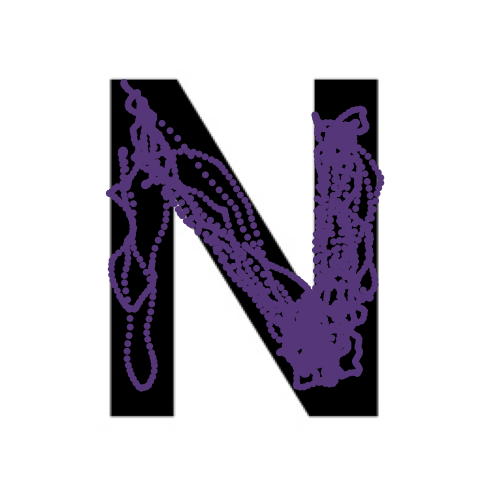

In [74]:
skip = 1; stop = -1;
NU_color = 0.9*np.array([94./255., 61./255., 134./255])
plt.figure(figsize=(5,5),dpi=100)
plt.imshow(img,cmap="gist_gray",extent=display_range)
plt.scatter(xtraj[var_ind[0],:stop:skip],xtraj[var_ind[1],:stop:skip],color=NU_color,s=25,marker='o',edgecolor='none')
plt.xlim([display_range[0],display_range[1]])
plt.ylim([display_range[2],display_range[3]])
plt.axis('off')
plt.tight_layout()
plt.show()

In [53]:
plt.close('all')